In [1201]:
# File Imports
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import matplotlib.ticker as ticker
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# Needed for decision tree visualization
import pydotplus 
from IPython.display import Image

# Suppress Warnings
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.simplefilter("ignore", category=FutureWarning)

## Step 1: Load Salary data and perform binning

In [1202]:
# Import the data:
file_location = "./resources/data_science_salaries.csv"
file_path = Path(file_location)

salary_df = pd.read_csv(file_path)

# salary_cap = 320000
# salary_df = salary_df.loc[salary_df["salary_in_usd"] <= salary_cap]

# Display the DataFrame:
salary_df.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


<module 'matplotlib.pyplot' from '/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

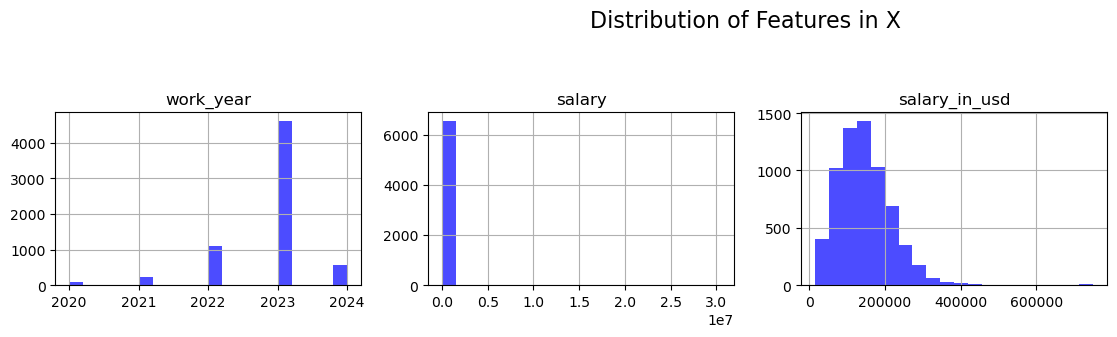

In [1203]:
# Graph Feature Dat:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each feature in X
X = salary_df.select_dtypes(include=['float64', 'int64'])  # Select numerical features
X.hist(bins=20, figsize=(15, 10), layout=(4, 4), color='blue', alpha=0.7)
plt.suptitle('Distribution of Features in X', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt

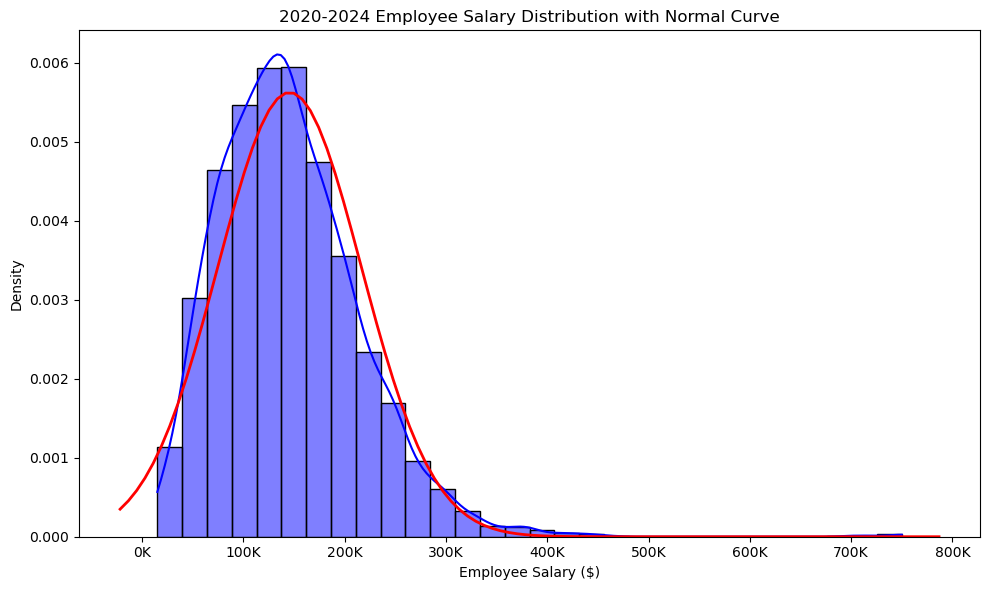

In [1204]:
# Choose a specific column from X or y
feature_to_plot = X.iloc[:, 2]  # Replace 2 with the actual column index you want

# Check if the data is numeric. If not, you can't scale it.
if not pd.api.types.is_numeric_dtype(feature_to_plot):
    print("Error: The selected feature is not numeric. Cannot scale.")
    exit() # Or handle the non-numeric case appropriately

# Scale the data by 1000 (if it's salary or similar):
feature_to_plot_scaled = feature_to_plot / 1000

# Plot the histogram with KDE using the SCALED data:
plt.figure(figsize=(10, 6))
sns.histplot(feature_to_plot_scaled, kde=True, stat="density", color="blue", bins=30)

# Overlay the normal distribution (using the SCALED mean and std):
mean_scaled = feature_to_plot_scaled.mean()
std_scaled = feature_to_plot_scaled.std()
xmin_scaled, xmax_scaled = plt.xlim()
x_scaled = np.linspace(xmin_scaled, xmax_scaled, 100)
p_scaled = norm.pdf(x_scaled, mean_scaled, std_scaled)
plt.plot(x_scaled, p_scaled, 'r', linewidth=2)


plt.title('2020-2024 Employee Salary Distribution with Normal Curve')  # More general title
plt.xlabel('Employee Salary ($)')  # More general x-axis label
plt.ylabel('Density')

# Format x-axis ticks to show thousands (if applicable):
def format_thousands(x, pos):
    return f'{x:.0f}K'

formatter = ticker.FuncFormatter(format_thousands)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig("./images/salary_distribution_scaled.png", dpi=300)
plt.show()

In [1205]:
# Data Partitioning: Attempt 1 of 2: Calculate the average range based on the 68% of the Empirical rule
mean_salary = np.mean(feature_to_plot)
std_salary = np.std(feature_to_plot)

lower_bound = mean_salary - std_salary
upper_bound = mean_salary + std_salary

print(f"68% range: ({lower_bound}, {upper_bound})")

68% range: (74619.09627855755, 216502.0208604029)


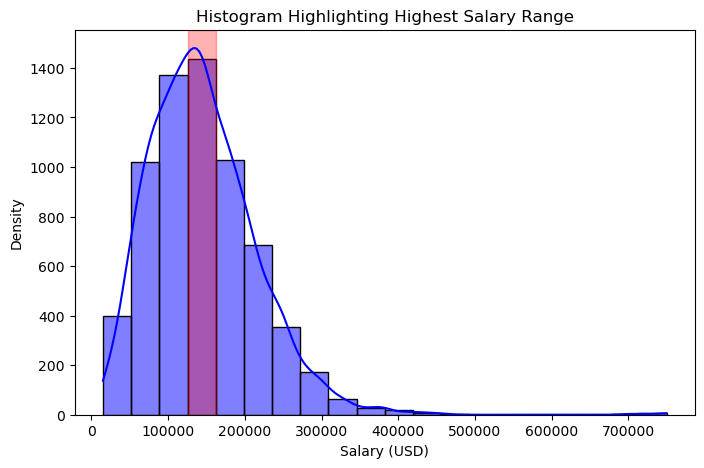

Highest salary range: 125,250.00 - 162,000.00


In [1206]:
# Data Partitionaing: Attempt 2 of 2: Using the two highest bars as the average
counts, bin_edges = np.histogram(feature_to_plot, bins=20)

# Find the index of the highest bar
highest_index = np.argmax(counts)

# Get the corresponding salary range
highest_range = (bin_edges[highest_index], bin_edges[highest_index + 1])

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(feature_to_plot, bins=20, kde=True, color="blue", alpha=0.5)

# Highlight the highest bar
plt.axvspan(highest_range[0], highest_range[1], color="red", alpha=0.3)

plt.xlabel("Salary (USD)")
plt.ylabel("Density")
plt.title("Histogram Highlighting Highest Salary Range")

plt.show()

# Print the identified range
print(f"Highest salary range: {highest_range[0]:,.2f} - {highest_range[1]:,.2f}")

In [1207]:
# Binning Employee Salary (y):

# Visual observation of the range of the Highest two bars
# Better accuracy for Average Salary @81%
bins = [1500, 50000, 156000, 176000, 750000]

# Peak salaries as average
# bins = [1500, 60000, 125000, 175000, 750000]

# Better recal in the classification report for low salaries 80%
# bins = [1500, 60000, 130000, 160000, 750000]


# Statical calculation of the range for the Highest two bars
# bins = [1500, 50000, 85000, 162000, 750000]

# Evenly distributed bins:
# bins = [1500, 50000, 100000, 140000, 750000]

# 5 distribution split
# bins = [1500, 50000, 100000, 140000, 200000, 750000] 

# PDCUT: Binning
# salary_df["Employee Salary"], bin_edges = pd.qcut(salary_df["salary_in_usd"], q=4, labels=False, retbins=True)

# Create labels for these bins
group_names = ["very low", "low", "average", "high"]

salary_data = X["salary_in_usd"]
# Slice the data and place it into bins
binned_data = pd.cut(salary_data, bins, labels=group_names, include_lowest=True)
display("Binned Data:", binned_data)
display("Binned Data Info")
binned_data.info()
salary_binned = pd.DataFrame()

# Place the data series into Employee Salary DataFrame
salary_binned["Employee Salary"] = binned_data


'Binned Data:'

0            low
1            low
2            low
3            low
4            low
          ...   
6594    very low
6595    very low
6596         low
6597         low
6598         low
Name: salary_in_usd, Length: 6599, dtype: category
Categories (4, object): ['very low' < 'low' < 'average' < 'high']

'Binned Data Info'

<class 'pandas.core.series.Series'>
RangeIndex: 6599 entries, 0 to 6598
Series name: salary_in_usd
Non-Null Count  Dtype   
--------------  -----   
6599 non-null   category
dtypes: category(1)
memory usage: 6.8 KB


## Step 2: Calculate the employee count and avg salary, per category

In [1208]:
# Create DataFrame with binned categories and original salaries
salary_and_bin = pd.DataFrame({"Employee Salary": salary_data, "Salary Bin": binned_data})


# Compute count and mean for each bin
salary_stats = salary_and_bin.groupby("Salary Bin", observed=False)["Employee Salary"].agg(['count', 'mean'])
# Rename columns for clarity
salary_stats.columns = ["Employee Count", "Average Salary"]

# Display as a table
print(salary_stats)

            Employee Count  Average Salary
Salary Bin                                
very low               383    37378.916449
low                   3651   108564.775952
average                652   166347.731595
high                  1913   230741.914794


## Step 3: Data Preprocessing

In [1209]:
# Load X dataset:
# Drop collinear data:
X = salary_df.copy()
# X = X.drop(columns=["salary", "salary_currency", "salary_in_usd", "work_year"], axis=1)
X = X.drop(columns=["salary", "salary_currency", "salary_in_usd"], axis=1)

display("X Info:")
X.info()
display("X Data:", X.head())
display("Work Model value_counts:", X["work_models"].value_counts())

# Get Nominal Column Names Only
nominal_features = X.select_dtypes(include="object").columns

'X Info:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   work_year           6599 non-null   int64 
 5   employee_residence  6599 non-null   object
 6   company_location    6599 non-null   object
 7   company_size        6599 non-null   object
dtypes: int64(1), object(7)
memory usage: 412.6+ KB


'X Data:'

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,United States,Medium


'Work Model value_counts:'

work_models
On-site    3813
Remote     2561
Hybrid      225
Name: count, dtype: int64

In [1210]:
# Load Y dataset:
y = binned_data
display("X shape:", X.shape)
display("y data:", y[0:5])
display("Y Info:")
y.info()

display("Y shape:", y.shape)
display("Y Describe:", y.describe())
# Check Y distribution
display("Y Value Counts:", y.value_counts())


'X shape:'

(6599, 8)

'y data:'

0    low
1    low
2    low
3    low
4    low
Name: salary_in_usd, dtype: category
Categories (4, object): ['very low' < 'low' < 'average' < 'high']

'Y Info:'

<class 'pandas.core.series.Series'>
RangeIndex: 6599 entries, 0 to 6598
Series name: salary_in_usd
Non-Null Count  Dtype   
--------------  -----   
6599 non-null   category
dtypes: category(1)
memory usage: 6.8 KB


'Y shape:'

(6599,)

'Y Describe:'

count     6599
unique       4
top        low
freq      3651
Name: salary_in_usd, dtype: object

'Y Value Counts:'

salary_in_usd
low         3651
high        1913
average      652
very low     383
Name: count, dtype: int64

## Step 4: Data Encoding

In [1211]:
# Preprocessing: Convert Nominal to Ordinal Data with Get Dummies:

X_encoded = pd.get_dummies(X, columns=nominal_features, drop_first=True, dtype=int)
# y_encoded = pd.get_dummies(y, drop_first=True, dtype=int)
le = LabelEncoder()
# One column only (reshape)
y_encoded = le.fit_transform(y)
y_encoded_1_dim = y_encoded
# print("y_encoded:", y_encoded.tolist())
# display("y_encoded:", y_encoded)

y_encoded = y_encoded.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, random_state=1)

# Ensure y_train is 1D after splitting
y_train = y_train.ravel()
y_test = y_test.ravel()

display("xTrain:", X_train)
display("yTrain:", y_train)


'xTrain:'

,work_year,job_title_AI Developer,job_title_AI Engineer,job_title_AI Product Manager,job_title_AI Programmer,job_title_AI Research Engineer,job_title_AI Scientist,job_title_AWS Data Architect,job_title_Analytics Engineer,job_title_Analytics Engineering Manager,...,company_location_Switzerland,company_location_Thailand,company_location_Turkey,company_location_Ukraine,company_location_United Arab Emirates,company_location_United Kingdom,company_location_United States,company_location_Vietnam,company_size_Medium,company_size_Small
477,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1989,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
711,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3234,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2857,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
5192,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3980,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
235,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


'yTrain:'

array([1, 1, 2, ..., 0, 1, 1])

## Step 5: BaseCase: Training 5 Classification Models

In [1212]:
# Baseline Pipeline Model Fitting:
# pipe = Pipeline([("Scale", StandardScaler()), ("LR", LinearRegression())])
# KNeighborsClassifier(n_neighbors=5)

models = {
    # Use odd generic number (5) for n_neighbors tie breakers 
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    # Use generic max_depth of 5
    "DTC": DecisionTreeClassifier(max_depth=5),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier(algorithm="SAMME")
}

for name, model in models.items():
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])
                                                
    # Fit (Train) the Model
    pipe.fit(X_train, y_train)

    # Make a prediction
    y_pred = pipe.predict(X_test)
    
    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

KNN Score: 0.5606060606060606
              precision    recall  f1-score   support

           0       0.16      0.07      0.10       165
           1       0.44      0.61      0.51       448
           2       0.68      0.66      0.67       945
           3       0.36      0.20      0.25        92

    accuracy                           0.56      1650
   macro avg       0.41      0.38      0.38      1650
weighted avg       0.55      0.56      0.55      1650

SVC Score: 0.5933333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.50      0.38      0.43       448
           2       0.62      0.84      0.72       945
           3       0.46      0.14      0.22        92

    accuracy                           0.59      1650
   macro avg       0.40      0.34      0.34      1650
weighted avg       0.52      0.59      0.54      1650

DTC Score: 0.6066666666666667
              precision    recall  f1-sc

## Step 6: Model Optimization

In [1213]:
# Part 1: Scale and Split data and find Best KNN value:
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 5, Train Score: 0.604 | Test Score: 0.561
k: 7, Train Score: 0.606 | Test Score: 0.572
k: 9, Train Score: 0.612 | Test Score: 0.590
k: 11, Train Score: 0.609 | Test Score: 0.590
k: 13, Train Score: 0.612 | Test Score: 0.596
k: 15, Train Score: 0.608 | Test Score: 0.597
k: 17, Train Score: 0.608 | Test Score: 0.598
k: 19, Train Score: 0.610 | Test Score: 0.604
k: 21, Train Score: 0.608 | Test Score: 0.604
k: 23, Train Score: 0.604 | Test Score: 0.601


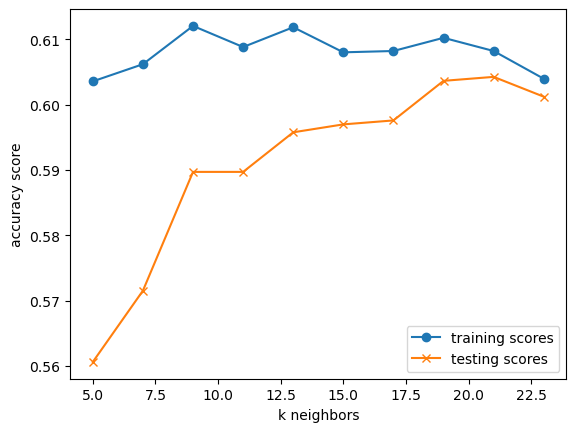

In [1214]:
# KNN Optimization 1: Find Best K_nearest neighbor value
train_scores = []
test_scores = []

for k in range(5, 25, 2):
    # Use KNN Classifer Model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Score for training
    train_score = knn.score(X_train_scaled, y_train)
    
    # Score for the test
    test_score = knn.score(X_test_scaled, y_test)
    
    # add the caculated scores to the list we just calculated
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train Score: {train_score:.3f} | Test Score: {test_score:.3f}")
    
# PyPlot Library: Plot the results
# Plot training scores, we need the saved k range for x axis on plot
# Optimal score would be 9, because that is where the testing scores are
# better than our training data.  The first whole number after the testing 
# and training data cross
plt.plot(range(5, 25, 2), train_scores, marker='o', label="training scores")
plt.plot(range(5, 25, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

In [1215]:
# KNN Optimation 1: Results with best KNN value:
knn_21 = KNeighborsClassifier(n_neighbors=21)
knn_21.fit(X_train_scaled, y_train)
print('k=21 Test Acc: %.3f' % knn_21.score(X_test_scaled, y_test))
predictions_knn_21 = knn_21.predict(X_test_scaled)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_knn_21, target_names=target_names, zero_division=0))

k=21 Test Acc: 0.604
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.47      0.62      0.53       448
           2       0.68      0.75      0.71       945
           3       0.79      0.12      0.21        92

    accuracy                           0.60      1650
   macro avg       0.48      0.37      0.36      1650
weighted avg       0.56      0.60      0.56      1650



In [1216]:
# KNN Optimization 2: Untuned KNN Model Classification Results
untuned_model = KNeighborsClassifier(n_neighbors=5)
untuned_model.fit(X_train_scaled, y_train)
print('Untuned_Model Accuracy Score: %.3f' % untuned_model.score(X_test_scaled, y_test))
# predicted
predictions_untuned = untuned_model.predict(X_test_scaled)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_untuned, target_names=target_names, zero_division=0))

Untuned_Model Accuracy Score: 0.561
              precision    recall  f1-score   support

           0       0.16      0.07      0.10       165
           1       0.44      0.61      0.51       448
           2       0.68      0.66      0.67       945
           3       0.36      0.20      0.25        92

    accuracy                           0.56      1650
   macro avg       0.41      0.38      0.38      1650
weighted avg       0.55      0.56      0.55      1650



In [1217]:
# KNN Optimiataion 2a:  RandomizedSearchCV Estimator
random_tuned_model = KNeighborsClassifier(n_neighbors=5)
random_parameters = {
    "n_neighbors": np.arange(5, 21, 2),
    "leaf_size": np.arange(1, 501),
    "weights": ["uniform", "distance"]
}

random_tuned_model = RandomizedSearchCV(random_tuned_model, random_parameters, verbose=3)

random_tuned_model.fit(X_train_scaled, y_train)

target_names = ["0", "1", "2", "3"]

# List the best parameters for this dataset
print("BEST FIT:", random_tuned_model.best_params_)

# Make predictions with the hypertuned model
predications_random = random_tuned_model.predict(X_test_scaled)
print(classification_report(y_test, predications_random,target_names=target_names, zero_division=0))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END leaf_size=131, n_neighbors=19, weights=uniform;, score=0.565 total time=   0.1s
[CV 2/5] END leaf_size=131, n_neighbors=19, weights=uniform;, score=0.592 total time=   0.0s
[CV 3/5] END leaf_size=131, n_neighbors=19, weights=uniform;, score=0.582 total time=   0.0s
[CV 4/5] END leaf_size=131, n_neighbors=19, weights=uniform;, score=0.598 total time=   0.1s
[CV 5/5] END leaf_size=131, n_neighbors=19, weights=uniform;, score=0.572 total time=   0.0s
[CV 1/5] END leaf_size=145, n_neighbors=13, weights=distance;, score=0.535 total time=   0.0s
[CV 2/5] END leaf_size=145, n_neighbors=13, weights=distance;, score=0.574 total time=   0.0s
[CV 3/5] END leaf_size=145, n_neighbors=13, weights=distance;, score=0.572 total time=   0.0s
[CV 4/5] END leaf_size=145, n_neighbors=13, weights=distance;, score=0.587 total time=   0.0s
[CV 5/5] END leaf_size=145, n_neighbors=13, weights=distance;, score=0.555 total time=   0.1s
[CV 

In [1218]:
# KNN Optimization 2b: Rerun model with RandomizedSearchCV Best Fit Estimator
# Use the best parameters found
random_tuned_model = KNeighborsClassifier(
    n_neighbors=17,  # Best fit value
    leaf_size=287,    # Best fit value
    weights="uniform" # Best fit value
    )

random_tuned_model.fit(X_train_scaled, y_train)
print('Random Model Accuracy Score: %.3f' % random_tuned_model.score(X_test_scaled, y_test))

# predicted
predictions_tuned = random_tuned_model.predict(X_test_scaled)
target_names = ["0", "1", "2", "3"]
print(classification_report(y_test, predictions_tuned, target_names=target_names, zero_division=0))

Random Model Accuracy Score: 0.598
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.46      0.56      0.51       448
           2       0.66      0.76      0.71       945
           3       0.80      0.13      0.22        92

    accuracy                           0.60      1650
   macro avg       0.48      0.36      0.36      1650
weighted avg       0.55      0.60      0.56      1650



In [1219]:
# Optimization 3: RandomOverSampling and RandomUnderSampling
# Deterimine if  y_encoded is unbalanced:  
# Results indicate uneven distribution, between class 3 (least) and 2 (most)
# Recommendation: OverSampling


print("y_encoded:")
display(pd.Series(y_encoded_1_dim).value_counts())
'''
Class 2 has 3651 samples (dominant class).
Class 1 has 1913 samples.
Class 0 has 652 samples.
Class 3 has 383 samples (least frequent).
'''

y_encoded:


2    3651
1    1913
0     652
3     383
Name: count, dtype: int64

'\nClass 2 has 3651 samples (dominant class).\nClass 1 has 1913 samples.\nClass 0 has 652 samples.\nClass 3 has 383 samples (least frequent).\n'

In [1220]:
# Optimization 3a: RandomOverSampling
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_oversampled, y_train_oversampled = over_sampler.fit_resample(X_train, y_train)

# Check new distribution
print("Oversampled Class Distribution")
print(pd.Series(y_train_oversampled).value_counts())

Oversampled Class Distribution
1    2706
2    2706
3    2706
0    2706
Name: count, dtype: int64


In [1221]:
# Optimization 3b: Rerun Models with RandomOverSampling dataset
# Results Worse
models = {
    "KNN": KNeighborsClassifier(
    n_neighbors=15,  # Best fit value
    leaf_size=221,    # Best fit value
    weights="uniform" # Best fit value
    ),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_oversampled, y_train_oversampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

KNN Score: 0.5066666666666667
              precision    recall  f1-score   support

           0       0.14      0.16      0.15       165
           1       0.46      0.51      0.48       448
           2       0.67      0.55      0.60       945
           3       0.33      0.67      0.44        92

    accuracy                           0.51      1650
   macro avg       0.40      0.47      0.42      1650
weighted avg       0.54      0.51      0.52      1650

SVC Score: 0.4036363636363636
              precision    recall  f1-score   support

           0       0.13      0.58      0.22       165
           1       0.52      0.40      0.45       448
           2       0.78      0.34      0.48       945
           3       0.38      0.71      0.49        92

    accuracy                           0.40      1650
   macro avg       0.45      0.51      0.41      1650
weighted avg       0.62      0.40      0.45      1650

DTC Score: 0.4678787878787879
              precision    recall  f1-sc

In [1222]:
# Optimization 4a: RandomUnderSampling:
# Apply Random Under Sampling
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=1)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

# Check new distribution
print(pd.Series(y_train_undersampled).value_counts())

0    291
1    291
2    291
3    291
Name: count, dtype: int64


In [1223]:
# Optimization 4b: Rerun Models with UnderSampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()  
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_undersampled, y_train_undersampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'Score: {name}; {pipe.score(X_test, y_test)}')
    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


Score: KNN; 0.27151515151515154
KNN Score: 0.27151515151515154
              precision    recall  f1-score   support

           0       0.12      0.78      0.21       165
           1       0.38      0.17      0.24       448
           2       0.80      0.20      0.31       945
           3       0.34      0.61      0.43        92

    accuracy                           0.27      1650
   macro avg       0.41      0.44      0.30      1650
weighted avg       0.60      0.27      0.29      1650

Score: SVC; 0.4
SVC Score: 0.4
              precision    recall  f1-score   support

           0       0.14      0.39      0.20       165
           1       0.46      0.57      0.51       448
           2       0.79      0.28      0.42       945
           3       0.26      0.78      0.39        92

    accuracy                           0.40      1650
   macro avg       0.41      0.51      0.38      1650
weighted avg       0.60      0.40      0.42      1650

Score: DTC; 0.39212121212121215
DTC 

In [1224]:
# Optimization 5a: SMOTEENN ReSampling:
# Apply Random Under Sampling
smt_sampler = SMOTEENN(sampling_strategy='auto', random_state=1)
X_train_resampled, y_train_resampled = smt_sampler.fit_resample(X_train, y_train)

# Check new distribution
print("Classification Distribution")
print(pd.Series(y_train_resampled).value_counts())

Classification Distribution
3    2202
0     629
2     378
1     290
Name: count, dtype: int64


In [1225]:
# Optimization 5b: Rerun Models with SMOTEEN Resampled data:
# Results Worse
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='rbf'),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier()
}

# Run models on the resampled training data
for name, model in models.items():
    # Create the pipeline
    pipe = Pipeline([("Scale", StandardScaler()), (name, model)])

    # Fit the pipeline on the resampled training data
    pipe.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    print(f'{name} Score: {pipe.score(X_test, y_test)}')
    target_names = ["0", "1", "2", "3"]
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))


KNN Score: 0.3903030303030303
              precision    recall  f1-score   support

           0       0.12      0.37      0.18       165
           1       0.48      0.27      0.34       448
           2       0.65      0.42      0.51       945
           3       0.25      0.75      0.38        92

    accuracy                           0.39      1650
   macro avg       0.37      0.45      0.35      1650
weighted avg       0.53      0.39      0.42      1650

SVC Score: 0.34424242424242424
              precision    recall  f1-score   support

           0       0.12      0.52      0.20       165
           1       0.51      0.31      0.39       448
           2       0.75      0.28      0.41       945
           3       0.25      0.86      0.38        92

    accuracy                           0.34      1650
   macro avg       0.41      0.49      0.34      1650
weighted avg       0.59      0.34      0.38      1650

DTC Score: 0.4103030303030303
              precision    recall  f1-s

In [1226]:
# Optimization 6a: AdaBoost RandomizedSearchCV Estimator
random_tuned_model = AdaBoostClassifier()
# AdaBoost Parameter Grid
param_grid = {
    "n_estimators": np.arange(50, 201, 2),  # Example: Number of weak learners
    "learning_rate": np.logspace(-3, 0, 20),  # Example: Learning rate (log scale)
    "algorithm": ['SAMME', 'SAMME'] #SAMME.R converges faster
}

# RandomizedSearchCV for AdaBoost
random_tuned_model = RandomizedSearchCV(
    AdaBoostClassifier(), 
    param_grid, 
    n_iter=10, 
    cv=5, 
    verbose=3, 
    n_jobs=-1, 
    scoring='accuracy', #Added scoring and cross validation
    random_state=61 #Added random state
)

random_tuned_model.fit(X_train, y_train)

target_names = ["0", "1", "2", "3"]

# Best Parameters
print("BEST FIT:", random_tuned_model.best_params_)

# Predictions
predictions_random = random_tuned_model.predict(X_test)
print(classification_report(y_test, predictions_random, target_names=target_names, zero_division=0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 5/5] END algorithm=SAMME, learning_rate=0.012742749857031334, n_estimators=74;, score=0.547 total time=   0.8s
[CV 2/5] END algorithm=SAMME, learning_rate=0.012742749857031334, n_estimators=74;, score=0.546 total time=   0.8s
[CV 1/5] END algorithm=SAMME, learning_rate=0.012742749857031334, n_estimators=74;, score=0.547 total time=   0.9s
[CV 3/5] END algorithm=SAMME, learning_rate=0.012742749857031334, n_estimators=74;, score=0.546 total time=   0.9s
[CV 4/5] END algorithm=SAMME, learning_rate=0.012742749857031334, n_estimators=74;, score=0.546 total time=   0.9s
[CV 4/5] END algorithm=SAMME, learning_rate=0.11288378916846883, n_estimators=150;, score=0.546 total time=   1.6s
[CV 2/5] END algorithm=SAMME, learning_rate=0.11288378916846883, n_estimators=150;, score=0.546 total time=   1.6s
[CV 5/5] END algorithm=SAMME, learning_rate=0.11288378916846883, n_estimators=150;, score=0.547 total time=   1.6s
[CV 3/5] END algori

In [1227]:
# Optimization 6b: Rerun AdaBoost with RandomizedSearchCV Best Fit:

best_params = {
    'n_estimators': 142, 
    'learning_rate': 0.4832930238571752,
    'random_state': 61}

# Create and train the AdaBoost classifier with the best parameters
best_ada = AdaBoostClassifier(**best_params)  # Use ** to unpack the dictionary
best_ada.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_ada.predict(X_test)

print(f'AdaBoost Score: {best_ada.score(X_test, y_test)}')


# Evaluate the model
target_names = ["0", "1", "2", "3"]  # Your target names
print(classification_report(y_test, predictions, target_names=target_names, zero_division=0))

AdaBoost Score: 0.6321212121212121
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       165
           1       0.53      0.49      0.51       448
           2       0.67      0.83      0.74       945
           3       0.64      0.41      0.50        92

    accuracy                           0.63      1650
   macro avg       0.59      0.43      0.44      1650
weighted avg       0.61      0.63      0.59      1650



In [1228]:
# Optimization 7a: RandomForest RandomizedSearchCV Estimator
random_tuned_model = RandomForestClassifier()
# RandomForest Parameter Grid
param_grid = {
    "n_estimators": np.arange(50, 201, 10),
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# RandomizedSearchCV for AdaBoost
random_tuned_model = RandomizedSearchCV(
    RandomForestClassifier(), 
    param_grid, 
    n_iter=10, 
    cv=5, 
    verbose=3, 
    n_jobs=-1, 
    scoring='accuracy', #Added scoring and cross validation
    random_state=61 #Added random state
)

random_tuned_model.fit(X_train, y_train)

target_names = ["0", "1", "2", "3"]

# Best Parameters
print("BEST FIT:", random_tuned_model.best_params_)

# Predictions
predictions_random = random_tuned_model.predict(X_test)
print(classification_report(y_test, predictions_random, target_names=target_names, zero_division=0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=70;, score=0.590 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=70;, score=0.603 total time=   0.3s
[CV 3/5] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=70;, score=0.589 total time=   0.3s
[CV 4/5] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=70;, score=0.608 total time=   0.3s
[CV 5/5] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=70;, score=0.597 total time=   0.3s
[CV 2/5] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=80;, score=0.612 total time=   0.5s
[CV 3/5] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=80;, score=0.596 total time=   0.4s
[

In [1229]:
# Optimization 7b: Rerun RandomForest with RandomizedSearchCV Best Fit:

param_grid = {
    "n_estimators": 80,
    "max_depth": 50,
    "min_samples_split": 2,
    "min_samples_leaf": 2,
    "bootstrap": False
}

# Create and train the RandomForest classifier with the best parameters
rfc = rfc = RandomForestClassifier(**param_grid)  # Use ** to unpack the dictionary
rfc.fit(X_train, y_train)

# Make predictions on the test set
predictions = rfc.predict(X_test)

print(f'RFC Score: {rfc.score(X_test, y_test)}')


# Evaluate the model
target_names = ["0", "1", "2", "3"]  # Your target names
print(classification_report(y_test, predictions, target_names=target_names, zero_division=0))

RFC Score: 0.6175757575757576
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.56      0.31      0.40       448
           2       0.63      0.91      0.74       945
           3       0.68      0.23      0.34        92

    accuracy                           0.62      1650
   macro avg       0.47      0.36      0.37      1650
weighted avg       0.55      0.62      0.55      1650



### NEXT SECTION

### LINEAR REGRESSION CODE

### BELOW

In [1230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [1231]:
# Load Data
salary_df = pd.read_csv("resources/data_science_salaries.csv")
salary_df.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


In [1232]:
# Log Transform Salary to Handle Outliers
salary_df = salary_df.loc[salary_df["salary_in_usd"] <= 650000]
salary_df["salary_in_usd"] = np.log(salary_df["salary_in_usd"])

In [1233]:
# Selecting Features & Target
X = salary_df.drop(columns=["salary", "salary_currency", "salary_in_usd"])
y = salary_df["salary_in_usd"]

In [1234]:
# Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1235]:
# Identify Categorical and Numerical Features
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns

In [1236]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

In [1237]:
# Model Pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("ridge", Ridge(alpha=1.0))  # Regularized Linear Regression
])

In [1238]:
print(X_train.head())
print(y_train.head())

                            job_title experience_level employment_type  \
2591                   Data Scientist     Senior-level       Full-time   
4406            Data Science Engineer     Senior-level       Full-time   
6315             Data Science Manager     Senior-level       Full-time   
1897  Business Intelligence Developer        Mid-level       Full-time   
1643                Research Engineer        Mid-level       Full-time   

     work_models  work_year employee_residence company_location company_size  
2591     On-site       2023      United States    United States       Medium  
4406     On-site       2023      United States    United States       Medium  
6315     On-site       2021      United States    United States        Large  
1897      Remote       2023      United States    United States       Medium  
1643      Remote       2023      United States    United States       Medium  
2591    12.268014
4406    11.849398
6315    12.388394
1897    11.608236
1643    1

In [1239]:
# Train Model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [1240]:
# Convert back from log scale
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

In [1241]:
# Evaluate Model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"MSE: {mse:.4f}")

R²: 0.5211
Adjusted R²: 0.5181
MSE: 0.1434


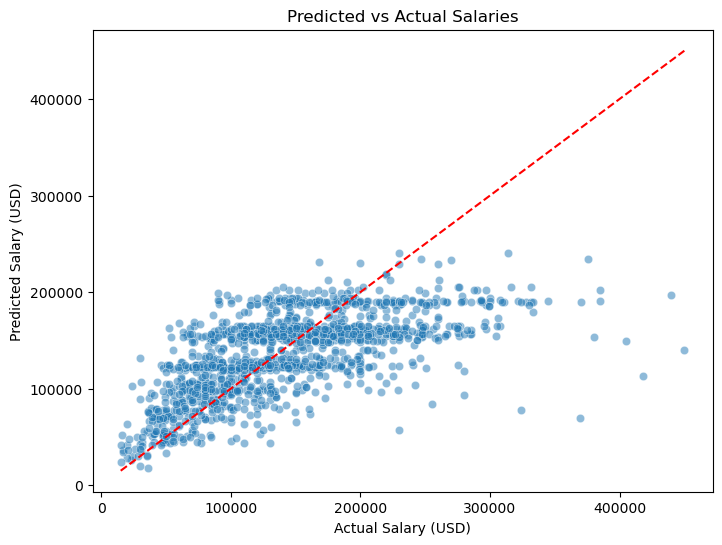

In [1242]:
# Plot Predicted vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_exp, y=y_pred_exp, alpha=0.5)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], color='red', linestyle='--')
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Predicted vs Actual Salaries")
plt.show()

### NEXT SECTION BELOW

### Unsupervised Learning

In [1243]:
# Unsupervised Learning File Imports
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.decomposition import PCA

In [1244]:
# Import the data:
file_location = "./resources/data_science_salaries.csv"
file_path = Path(file_location)

salary_df = pd.read_csv(file_path)
# Display the DataFrame:
salary_df.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


# Prepare the Data 

In [1245]:
# Drop the irrelevant columns, salary and salary currency
salary_df = salary_df.drop(columns=['salary', 'salary_currency', 'work_year'])
salary_df.head()

,job_title,experience_level,employment_type,work_models,employee_residence,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,United States,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,United States,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,United States,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,United States,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,United States,120000,United States,Medium


In [1246]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   employee_residence  6599 non-null   object
 5   salary_in_usd       6599 non-null   int64 
 6   company_location    6599 non-null   object
 7   company_size        6599 non-null   object
dtypes: int64(1), object(7)
memory usage: 412.6+ KB


In [1247]:
# Find the quartiles, IQR and outlier bounds
salaries = salary_df["salary_in_usd"]
Q1 = salaries.quantile(0.25)
median = salaries.quantile(0.5)
Q3 = salaries.quantile(0.75)
IQR = Q3 - Q1

print(f"The lower quartile of salary is: {Q1}")
print(f"The upper quartile of salary is: {Q3}")
print(f"The interquartile range of salary is: {IQR}")
print(f"The the median of salary is: {median} ")

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of salary is: 95000.0
The upper quartile of salary is: 185000.0
The interquartile range of salary is: 90000.0
The the median of salary is: 138666.0 
Values below -40000.0 could be outliers.
Values above 320000.0 could be outliers.


In [1248]:
# Exclude the outliers 
salary_df = salary_df.loc[salary_df['salary_in_usd'] <= upper_bound]
salary_df = salary_df.reset_index(drop=True)
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6492 entries, 0 to 6491
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6492 non-null   object
 1   experience_level    6492 non-null   object
 2   employment_type     6492 non-null   object
 3   work_models         6492 non-null   object
 4   employee_residence  6492 non-null   object
 5   salary_in_usd       6492 non-null   int64 
 6   company_location    6492 non-null   object
 7   company_size        6492 non-null   object
dtypes: int64(1), object(7)
memory usage: 405.9+ KB


## Encode Categorical Columns
Use Frequency encoder for columns with high cardinality.  Use Pandas get_dummies for columns with low cardinality


In [1249]:
# Check cardinality of columns
salary_df.nunique()

job_title              130
experience_level         4
employment_type          4
work_models              3
employee_residence      86
salary_in_usd         2090
company_location        75
company_size             3
dtype: int64

In [1250]:
# Frequency encoder
freq_features = ['job_title', 'employee_residence', 'company_location']
# freq_features = ['job_title', 'employee_residence', 'company_location', 'experience_level', 'employment_type', 'work_models', 'company_size']

encoded_df = salary_df.copy()
encoded_mappings = {} 

for col in freq_features:
    frequencies = salary_df[col].value_counts(normalize=True) # Calculate frequencies
    encoded_mappings[col] = frequencies.to_dict() # Store mapping

    encoded_df[col + '_freq'] = salary_df[col].map(frequencies) # Create new freq column
    encoded_df.drop(col, axis=1, inplace=True) # Drop original column (Optional)

print("Frequency Encoding Mappings:")
for col, mapping in encoded_mappings.items():
    print(f"Column '{col}': {mapping}")

Frequency Encoding Mappings:
Column 'job_title': {'Data Engineer': 0.19963031423290203, 'Data Scientist': 0.1899260628465804, 'Data Analyst': 0.13971041281577326, 'Machine Learning Engineer': 0.09426987060998152, 'Analytics Engineer': 0.03727664818237831, 'Research Scientist': 0.030345040049291436, 'Data Architect': 0.02649414664202095, 'Research Engineer': 0.019870609981515713, 'ML Engineer': 0.016173752310536044, 'Applied Scientist': 0.01463339494762785, 'Data Science Manager': 0.013093037584719655, 'Business Intelligence Analyst': 0.012630930375847197, 'Machine Learning Scientist': 0.010782501540357363, 'Business Intelligence Engineer': 0.010628465804066543, 'Data Manager': 0.009704251386321626, 'Research Analyst': 0.009242144177449169, 'Data Science': 0.008471965495995071, 'Data Specialist': 0.007239679605668515, 'AI Engineer': 0.006777572396796057, 'Data Science Consultant': 0.006469500924214418, 'BI Developer': 0.006315465187923599, 'Machine Learning Infrastructure Engineer': 0.0

In [1251]:
# Use Pandas one-hot encoder, get_dummies, for the columns with low cardinality

nominal_features = ['experience_level', 'employment_type', 'work_models', 'company_size']
encoded_df = pd.get_dummies(encoded_df, columns=nominal_features, drop_first=True, dtype=int)
encoded_df.head()

,salary_in_usd,job_title_freq,employee_residence_freq,company_location_freq,experience_level_Executive-level,experience_level_Mid-level,experience_level_Senior-level,employment_type_Freelance,employment_type_Full-time,employment_type_Part-time,work_models_On-site,work_models_Remote,company_size_Medium,company_size_Small
0,148100,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0
1,98700,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0
2,140032,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0
3,100022,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0
4,120000,0.006315,0.80191,0.809304,0,1,0,0,1,0,1,0,1,0


## Scale the salary_in_usd column

In [1252]:
# Use Standard Scaler to scale the salary_in_usd column
scaled_data = StandardScaler().fit_transform(encoded_df[['salary_in_usd']])
scaled_data[0:5]

array([[ 0.10633315],
       [-0.68580885],
       [-0.02303935],
       [-0.66461024],
       [-0.34425775]])

In [1253]:
# Create a DataFrame of the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=['salary_in_usd'])

# Copy the encoded data frame to cleaned_df, and update the scaled salary_in_usd
cleaned_df = encoded_df.copy()
cleaned_df['salary_in_usd'] = scaled_df['salary_in_usd']

cleaned_df.head()

,salary_in_usd,job_title_freq,employee_residence_freq,company_location_freq,experience_level_Executive-level,experience_level_Mid-level,experience_level_Senior-level,employment_type_Freelance,employment_type_Full-time,employment_type_Part-time,work_models_On-site,work_models_Remote,company_size_Medium,company_size_Small
0,0.106333,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0
1,-0.685809,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0
2,-0.023039,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0
3,-0.664610,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0
4,-0.344258,0.006315,0.80191,0.809304,0,1,0,0,1,0,1,0,1,0


In [1254]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6492 entries, 0 to 6491
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   salary_in_usd                     6492 non-null   float64
 1   job_title_freq                    6492 non-null   float64
 2   employee_residence_freq           6492 non-null   float64
 3   company_location_freq             6492 non-null   float64
 4   experience_level_Executive-level  6492 non-null   int64  
 5   experience_level_Mid-level        6492 non-null   int64  
 6   experience_level_Senior-level     6492 non-null   int64  
 7   employment_type_Freelance         6492 non-null   int64  
 8   employment_type_Full-time         6492 non-null   int64  
 9   employment_type_Part-time         6492 non-null   int64  
 10  work_models_On-site               6492 non-null   int64  
 11  work_models_Remote                6492 non-null   int64  
 12  compan

# Unsupervised ML Analysis

## Use the KMeans Elbow Method to Find the Best Number of clusters

In [1255]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=10)
    k_model.fit(cleaned_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {'k' : k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

# Review the DataFrame
elbow_df

,k,inertia
0,1,14768.631331
1,2,10073.432839
2,3,8433.806791
3,4,6843.016806
4,5,6125.955042
5,6,5253.066548
6,7,4925.634630
7,8,4375.997518
8,9,4142.818185
9,10,3991.949675


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

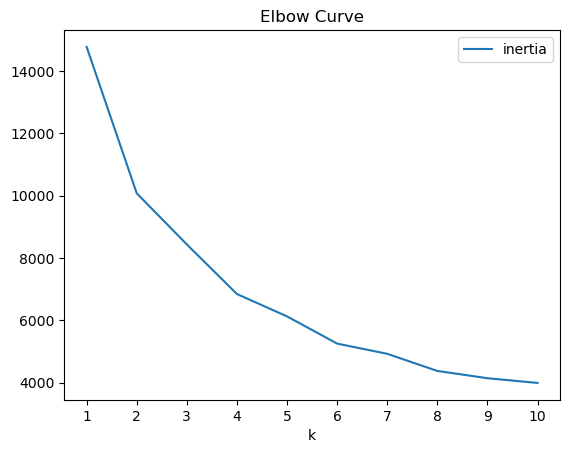

In [1256]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.plot.line(x='k',
                   y='inertia',
                   title="Elbow Curve", 
                   xticks = k)

### Use K-means to cluster data with the best k value

In [1257]:
# Initialize the K-Means model using the best value for k
k_model = KMeans(n_clusters=4, n_init='auto', random_state=10)

# Fit the K-Means model using the scaled data
k_model.fit(cleaned_df)

# Predict the clusters to group the cryptocurrencies using the scaled data
k_predictions = k_model.predict(cleaned_df)

# Create a copy of the preprocessed data
salary_predictions_df = cleaned_df.copy()

# Add a class column with the labels
salary_predictions_df['kmeans_segments'] = k_predictions

salary_predictions_df.head()

,salary_in_usd,job_title_freq,employee_residence_freq,company_location_freq,experience_level_Executive-level,experience_level_Mid-level,experience_level_Senior-level,employment_type_Freelance,employment_type_Full-time,employment_type_Part-time,work_models_On-site,work_models_Remote,company_size_Medium,company_size_Small,kmeans_segments
0,0.106333,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0,3
1,-0.685809,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0,0
2,-0.023039,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0,3
3,-0.664610,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0,3
4,-0.344258,0.006315,0.80191,0.809304,0,1,0,0,1,0,1,0,1,0,2


<Axes: xlabel='job_title_freq', ylabel='salary_in_usd'>

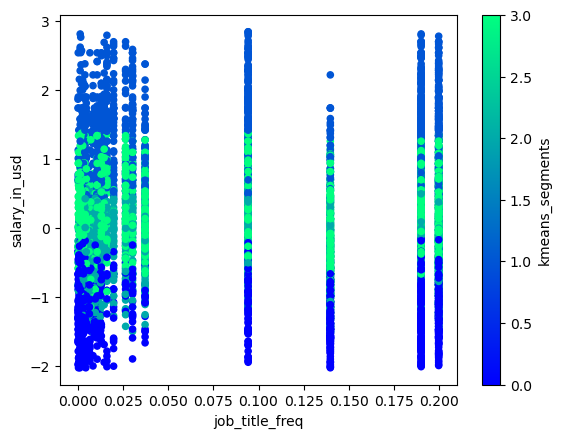

In [1258]:
# Plot the clusters
salary_predictions_df.plot.scatter(
    x='job_title_freq',
    y='salary_in_usd',
    c='kmeans_segments',
    colormap='winter'
)

### Use Brich and AgglomerativeClustering to cluster data

In [1259]:
# Fit a AgglomerativeClustering Model
agglo_model = AgglomerativeClustering(n_clusters=4)

# Make predictions with the AgglomerativeClustering model
agglo_predictions = agglo_model.fit_predict(cleaned_df)

# Save the agglo segments
salary_predictions_df['agglo_segments'] = agglo_predictions


In [1260]:
# Fit a Brich Model with three clusters.
birch_model = Birch(n_clusters=4)
birch_model.fit(cleaned_df)

# Make predictions with the Birch model
birch_predictions = birch_model.predict(cleaned_df)

# Save the Birch segments
salary_predictions_df['brich_segments'] = birch_predictions

In [1261]:
salary_predictions_df.head()

,salary_in_usd,job_title_freq,employee_residence_freq,company_location_freq,experience_level_Executive-level,experience_level_Mid-level,experience_level_Senior-level,employment_type_Freelance,employment_type_Full-time,employment_type_Part-time,work_models_On-site,work_models_Remote,company_size_Medium,company_size_Small,kmeans_segments,agglo_segments,brich_segments
0,0.106333,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0,3,0,0
1,-0.685809,0.199630,0.80191,0.809304,0,1,0,0,1,0,0,1,1,0,0,0,0
2,-0.023039,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0,3,1,0
3,-0.664610,0.189926,0.80191,0.809304,0,0,1,0,1,0,0,1,1,0,3,1,0
4,-0.344258,0.006315,0.80191,0.809304,0,1,0,0,1,0,1,0,1,0,2,0,2


<Axes: xlabel='job_title_freq', ylabel='salary_in_usd'>

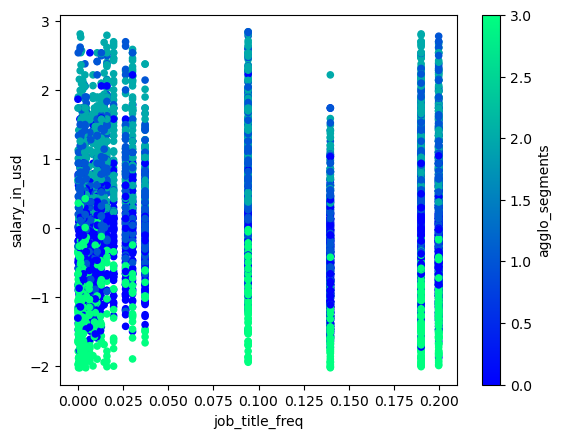

In [1262]:
# Plot the AgglomerativeClustering clusters
salary_predictions_df.plot.scatter(
    x='job_title_freq',
    y='salary_in_usd',
    c='agglo_segments',
    colormap='winter'
)

<Axes: xlabel='job_title_freq', ylabel='salary_in_usd'>

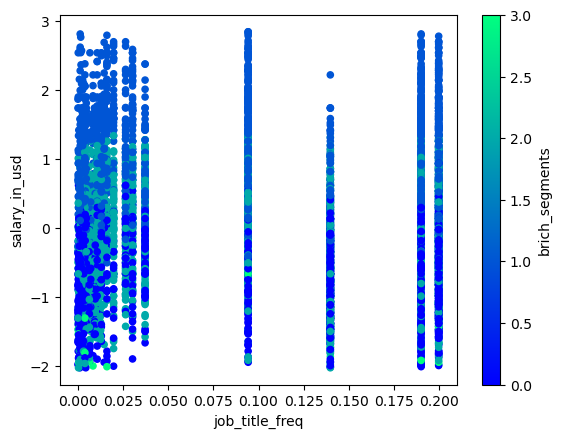

In [1263]:
# Plot the Birch clusters
salary_predictions_df.plot.scatter(
    x='job_title_freq',
    y='salary_in_usd',
    c='brich_segments',
    colormap='winter'
)

## Optimize Clusters with Principal Component Analysis.

In [1264]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

# Use the PCA model with `fit_transform` on the original scaled DataFrame to reduce to three principal components.
scaled_data_pca = pca.fit_transform(cleaned_df)

# View the first five rows of the DataFrame. 
scaled_data_pca[0:5]

array([[-0.17992901, -0.65626058, -1.02419293],
       [-0.92107126, -0.60482609, -0.79016441],
       [ 0.07760565, -0.87061016,  0.34571242],
       [-0.52265957, -0.82895239,  0.53525658],
       [-0.47600782,  0.76095361, -0.714205  ]])

In [1265]:
# Retrieve the explained variance to determine how much information  can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.48484917, 0.20563969, 0.13802023])

In [1266]:
# Create a new DataFrame with the PCA data.

# Creating a DataFrame with the PCA data
df_pca = pd.DataFrame(scaled_data_pca, columns=['PCA1', 'PCA2', 'PCA3'])

# Copy the crypto names from the original data
df_pca['index'] = cleaned_df.index

# Set the coinid column as index
df_pca = df_pca.set_index('index')

# Display sample data
df_pca.tail()

,PCA1,PCA2,PCA3
index,,,
6487,-1.817100,-0.103340,0.080910
6488,-2.088277,0.692723,0.308518
6489,-0.501417,-0.283443,0.441740
6490,-1.534734,-0.019127,-0.688447
6491,-0.844850,0.413851,0.643704


### Find the Best Value for k Using the PCA Data

In [1267]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, n_init='auto', random_state=10)
    k_model.fit(df_pca)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {'k' : k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)

# Review the DataFrame
elbow_df

,k,inertia
0,1,12235.945160
1,2,7544.864660
2,3,5748.109633
3,4,4479.098280
4,5,3484.633778
5,6,2894.592184
6,7,2529.604052
7,8,2114.601902
8,9,1749.805194
9,10,1595.859700


<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

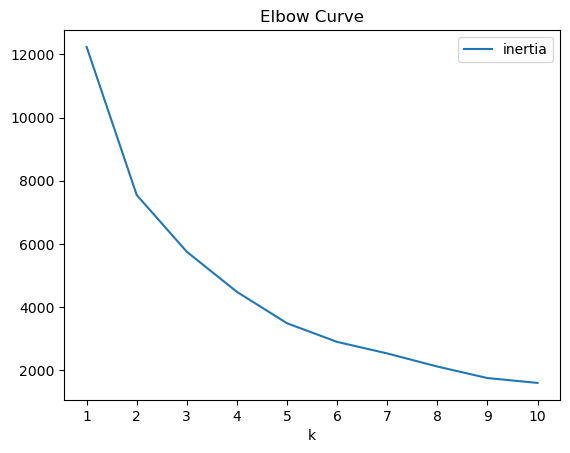

In [1268]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.plot.line(x='k',
                   y='inertia',
                   title="Elbow Curve", 
                   xticks = k)

In [1269]:
df_pca.head()

,PCA1,PCA2,PCA3
index,,,
0,-0.179929,-0.656261,-1.024193
1,-0.921071,-0.604826,-0.790164
2,0.077606,-0.870610,0.345712
3,-0.522660,-0.828952,0.535257
4,-0.476008,0.760954,-0.714205


In [1270]:
# Initialize the K-Means model using the best value for k
k_model = KMeans(n_clusters=3, n_init='auto', random_state=10)

# Fit the K-Means model using the scaled data
k_model.fit(df_pca)

# Predict the clusters to group the cryptocurrencies using the scaled data
k_predictions = k_model.predict(df_pca)

# Create a copy of the preprocessed data
pca_predictions_df = df_pca.copy()

# Add a class column with the labels
pca_predictions_df['kmeans_segments'] = k_predictions

pca_predictions_df.head()

,PCA1,PCA2,PCA3,kmeans_segments
index,,,,
0,-0.179929,-0.656261,-1.024193,0
1,-0.921071,-0.604826,-0.790164,0
2,0.077606,-0.870610,0.345712,0
3,-0.522660,-0.828952,0.535257,0
4,-0.476008,0.760954,-0.714205,2


<Axes: xlabel='PCA1', ylabel='PCA2'>

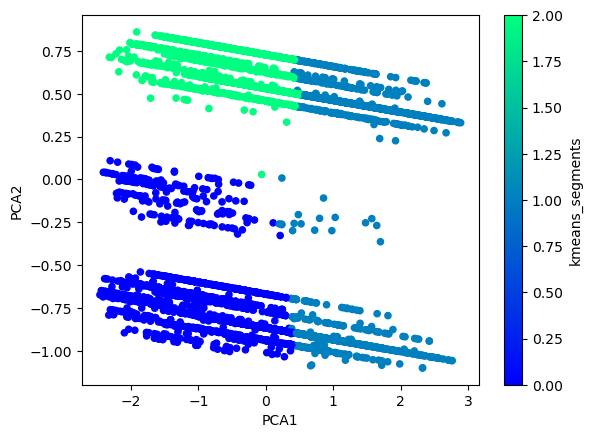

In [1271]:
# Plot the clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA2',
    c='kmeans_segments',
    colormap='winter'
)

### Use Brich and AgglomerativeClustering to cluster PCA data

In [1272]:
# Fit a AgglomerativeClustering Model
agglo_model = AgglomerativeClustering(n_clusters=3)

# Make predictions with the AgglomerativeClustering model
agglo_predictions = agglo_model.fit_predict(df_pca)

# Save the agglo segments
pca_predictions_df['agglo_segments'] = agglo_predictions

In [1273]:
# Fit a Birch Model
birch_model = Birch(n_clusters=3)
birch_model.fit(df_pca)

# Make predictions with the Birch model
birch_predictions = birch_model.predict(df_pca)

# Save the Birch segments
pca_predictions_df['brich_segments'] = birch_predictions


<Axes: xlabel='PCA1', ylabel='PCA2'>

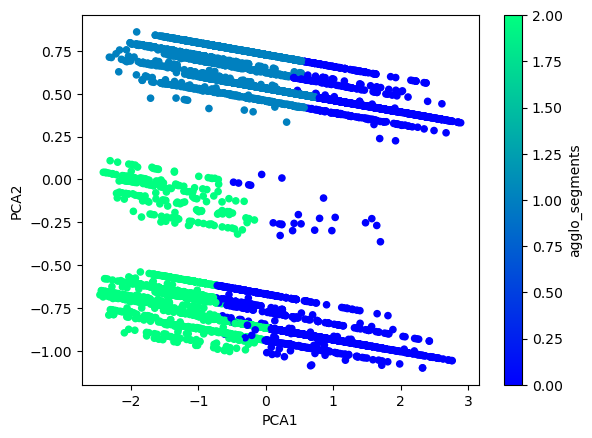

In [1274]:
# Plot the AgglomerativeClustering clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA2',
    c='agglo_segments',
    colormap='winter'
)

<Axes: xlabel='PCA1', ylabel='PCA2'>

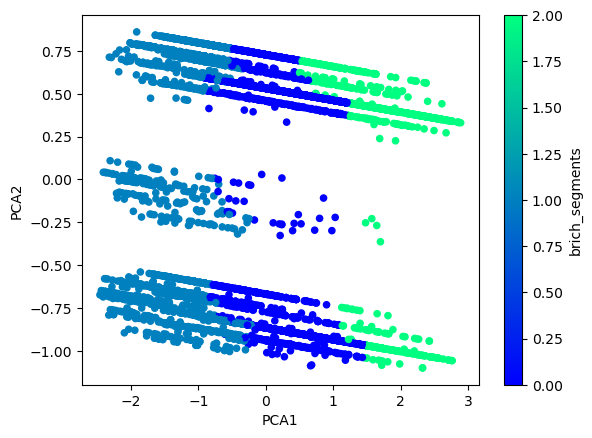

In [1275]:
# Plot the Birch clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA2',
    c='brich_segments',
    colormap='winter'
)

<Axes: xlabel='PCA1', ylabel='PCA3'>

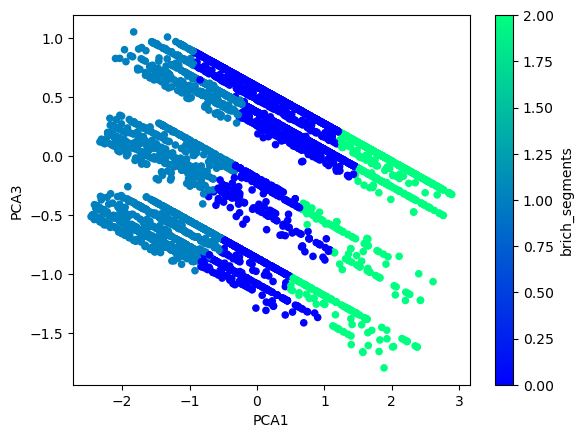

In [1276]:
# Plot the Birch clusters
pca_predictions_df.plot.scatter(
    x='PCA1',
    y='PCA3',
    c='brich_segments',
    colormap='winter'
)

In [1277]:
pca_component_weights = pd.DataFrame(pca.components_.T,
                                     columns=['PCA1', 'PCA2', 'PCA3'],
                                     index=cleaned_df.columns)
pca_component_weights

,PCA1,PCA2,PCA3
salary_in_usd,0.935618,-0.064931,-0.295438
job_title_freq,-0.001362,-0.002141,0.000273
employee_residence_freq,0.136931,0.041885,0.031001
company_location_freq,0.131220,0.034394,0.027901
experience_level_Executive-level,0.016352,-0.005647,-0.060735
experience_level_Mid-level,-0.157513,0.111862,-0.632370
experience_level_Senior-level,0.221052,-0.110908,0.699317
employment_type_Freelance,-0.002826,-0.001408,-0.000289
employment_type_Full-time,0.009158,0.006136,0.004271
employment_type_Part-time,-0.003644,-0.001461,-0.000682


In [1278]:
stat_by_work_models = salary_df.groupby(['work_models'])['salary_in_usd'].agg(['mean', 'median', 'count'])
stat_by_experience_level = salary_df.groupby(['experience_level'])['salary_in_usd'].agg(['mean', 'median', 'count'])

print(stat_by_work_models)
print("")
print(stat_by_experience_level)

                      mean    median  count
work_models                                
Hybrid        79023.234234   65844.0    222
On-site      147385.916957  140130.0   3733
Remote       138226.495073  135000.0   2537

                           mean    median  count
experience_level                                
Entry-level        83978.081560   75000.0    564
Executive-level   179390.317992  180000.0    239
Mid-level         114548.110441  106200.0   1657
Senior-level      158326.205605  152000.0   4032


In [1279]:
cleaned_df[['salary_in_usd', 'job_title_freq', 'employee_residence_freq', 'company_location_freq',
            'experience_level_Senior-level', 'work_models_On-site', 'employment_type_Full-time', 'company_size_Medium']].corr()

,salary_in_usd,job_title_freq,employee_residence_freq,company_location_freq,experience_level_Senior-level,work_models_On-site,employment_type_Full-time,company_size_Medium
salary_in_usd,1.000000,-0.021796,0.384800,0.370237,0.346067,0.110367,0.100423,0.187583
job_title_freq,-0.021796,1.000000,0.026637,0.016695,0.003490,-0.015452,0.048003,0.112919
employee_residence_freq,0.384800,0.026637,1.000000,0.969093,0.205974,0.167223,0.116506,0.281230
company_location_freq,0.370237,0.016695,0.969093,1.000000,0.194440,0.148801,0.075995,0.256374
experience_level_Senior-level,0.346067,0.003490,0.205974,0.194440,1.000000,0.021542,0.080170,0.156592
work_models_On-site,0.110367,-0.015452,0.167223,0.148801,0.021542,1.000000,0.078402,0.210504
employment_type_Full-time,0.100423,0.048003,0.116506,0.075995,0.080170,0.078402,1.000000,0.141067
company_size_Medium,0.187583,0.112919,0.281230,0.256374,0.156592,0.210504,0.141067,1.000000


# Output preprocessed data before scalling salary_in_usd

In [1280]:
display(encoded_df)

,salary_in_usd,job_title_freq,employee_residence_freq,company_location_freq,experience_level_Executive-level,experience_level_Mid-level,experience_level_Senior-level,employment_type_Freelance,employment_type_Full-time,employment_type_Part-time,work_models_On-site,work_models_Remote,company_size_Medium,company_size_Small
0,148100,0.199630,0.801910,0.809304,0,1,0,0,1,0,0,1,1,0
1,98700,0.199630,0.801910,0.809304,0,1,0,0,1,0,0,1,1,0
2,140032,0.189926,0.801910,0.809304,0,0,1,0,1,0,0,1,1,0
3,100022,0.189926,0.801910,0.809304,0,0,1,0,1,0,0,1,1,0
4,120000,0.006315,0.801910,0.809304,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6487,44753,0.000462,0.037123,0.037431,0,0,0,0,0,0,0,0,0,0
6488,15000,0.000462,0.001848,0.037431,1,0,0,0,1,0,1,0,1,0
6489,117104,0.000616,0.037123,0.037431,0,0,1,0,1,0,0,0,0,0
6490,74130,0.199630,0.000924,0.000924,0,1,0,0,1,0,0,0,0,0


In [1281]:
# Export to CSV
encoded_df.to_csv("resources/data_science_salaries_encoded.csv", index=False)


# out_file_location = "./resources/data_science_salaries_encoded.csv"
# out_file_path = Path(out_file_location)

# out_salary_df = pd.read_csv(out_file_path)
# # Display the DataFrame:
# out_salary_df.tail()